In [1]:
using AutoRisk
using PGFPlots

In [2]:
type BudgetTimer
    budget::Float64 # budget in seconds
    start_time::Float64
    pause_start::Float64
    function BudgetTimer(budget::Float64)
        new(budget, time())
    end
end

function has_time_remaining(timer::BudgetTimer)
    return (time() - timer.start_time) < timer.budget
end

function pause(timer::BudgetTimer)
    timer.pause_start = time()
end

function restart(timer::BudgetTimer)
    timer.start_time += time() - timer.pause_start
end

function past_fraction(timer::BudgetTimer, fraction::Float64)
    return (time() - timer.start_time) / timer.budget > fraction
end

past_fraction (generic function with 1 method)

In [3]:
abstract Agent
@with_kw type GaussianOneDAgent <: Agent
    μ::Float64 = 0.
    σ::Float64 = 1.
end
step(agent::GaussianOneDAgent, state::Array{Float64}) = [randn() * agent.σ + agent.μ]

abstract Env
@with_kw type OneDEnv <: Env
    xmin::Float64 = -10.
    xmax::Float64 = 10
    x::Array{Float64} = [0.]
end
function reset(env::OneDEnv) 
    env.x = [rand(env.xmin:1e-8:env.xmax)]
    env.x
end
function reset(env::OneDEnv, x::Array{Float64})
    env.x = x
end
function step(env::OneDEnv, a::Array{Float64})
    env.x += a[1]
    if env.x[1] > env.xmax
        r = 1.
        done = true
    elseif env.x[1] < env.xmin
        r = 0.
        done = true
    else
        r = 0.
        done = false
    end
    return (env.x, r, done)
end

step (generic function with 2 methods)

In [75]:
# budget, env, agent, learner, t_max, mc_runs, discount 
function fit(learner::PredictionModel, env::Env, agent::Agent; 
            budget::Float64 = 5., t_max::Int = 10, mc_runs::Int = 1, discount::Float64 = .99, 
        states::Array{Float64} = zeros(1), true_v = nothing, ncurve_pts::Int = 10)
    timer = BudgetTimer(budget)
    curve = Float64[]
    curve_pt = .6
    while has_time_remaining(timer)
        
        # collect data
        init_x = reset(env)
        v = [0.]
        x = copy(init_x)
        for run in 1:mc_runs
            copy!(x, init_x)
            reset(env, x)
            t, done = 0, false
            while t < t_max && !done
                a = step(agent, x)
                nx, r, done = step(env, a)
                x = nx
                t += 1
                v[1] += discount * r
            end
            
            # DP
            if !done
                v[1] += discount * predict(learner, x)[1]
            end
        end
        
        # train
        v /= mc_runs
        AutoRisk.update!(learner, reshape(init_x, 1, 1), reshape(v, 1, 1))
        
        # track progress if ground truth available
        if !(true_v == nothing) && past_fraction(timer, curve_pt / ncurve_pts)
            pause(timer)
            pred_v = predict(learner, states)
            push!(curve, sum(abs(true_v - pred_v)))
            curve_pt += 1.
            restart(timer)
        end
    end
    learner, curve
end

fit (generic function with 1 method)

In [87]:
# general constants
num_eval_steps = 200 # number of steps at which to evaluate learned policy

# env
env = OneDEnv(xmin = -20, xmax = 20)

# agent 
agent = GaussianOneDAgent(σ = 2.);

# learner 
nbins = 20
bins = linspace(env.xmin, env.xmax, nbins)
grid = RectangleGrid(bins)
target_dim = 1
learner = TDPredictor(grid, target_dim);

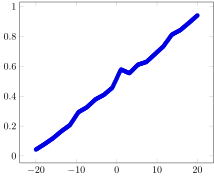

In [88]:
# get the true values
reset!(learner)
fit(learner, env, agent, budget = 50., t_max = 1000, mc_runs = 16);
states = reshape(collect(linspace(env.xmin, env.xmax, num_eval_steps)), 1, num_eval_steps)
true_v = predict(learner, states)
plot(states[1,:], true_v[1,:])

In [89]:
# compare different values
num_runs = 5 # number of times each run is executed
ncurve_pts = 20
budget = 5. # number of seconds for which it is executed
t_max_nbins, t_max_min, t_max_max = 4, 1, 1000
t_max_list = linspace(t_max_min, t_max_max, t_max_nbins)
t_max_list = map(x -> Int(ceil(x)), t_max_list)
mc_nbins, mc_min, mc_max = 4, 1, 50
mc_runs_list = linspace(mc_min, mc_max, mc_nbins)
mc_runs_list = map(x -> Int(ceil(x)), mc_runs_list)
results = zeros(t_max_nbins, mc_nbins)
vs = zeros(num_eval_steps, t_max_nbins, mc_nbins)
curves = zeros(ncurve_pts, num_runs, t_max_nbins, mc_nbins)
states = reshape(collect(linspace(env.xmin, env.xmax, num_eval_steps)), 1, num_eval_steps)
for (i, t_max) in enumerate(t_max_list)
    for (j, mc_runs) in enumerate(mc_runs_list)
        best_loss = Inf
        for run in 1:num_runs
            # fit
            reset!(learner)
            _, curve = fit(learner, env, agent, budget = budget, t_max = t_max, mc_runs = mc_runs, 
                states = states, true_v = true_v, ncurve_pts = ncurve_pts);
            v = predict(learner, states)
            
            # track results
            loss = sum(abs(true_v - v))
            results[i, j] += loss
            curves[:,run,i,j] = curve
            if loss < best_loss
                vs[:, i, j] = v
                best_loss = loss
            end
        end
        results[i,j] /= num_runs
    end
end

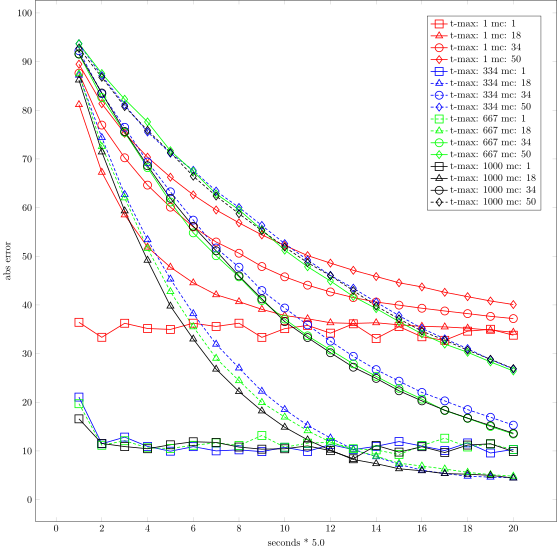

In [90]:
# plot the average learning curves
g = GroupPlot(t_max_nbins, mc_nbins, groupStyle = "horizontal sep = 1.5cm, vertical sep = 1.4cm")
a = Axis(legendPos="north east", width="20cm", height="20cm", xlabel="seconds * $(budget)", ylabel="abs error")
markcolors = ["red", "blue", "green", "black"]
markers = ["square", "triangle", "o", "diamond"]
for (i, t_max) in enumerate(t_max_list)
    markcolor = markcolors[i]
    for (j, mc_runs) in enumerate(mc_runs_list)
        marker = markers[j]
        avg_curve = mean(curves[:,:,i,j], 2)
        p = Plots.Linear(1:length(avg_curve), avg_curve[:,1], 
            legendentry="t-max: $(t_max) mc: $(mc_runs)",
        mark="$(marker)",
        style="$(markcolor),thick",
        markSize=4)
        push!(a, p)
    end
end
a

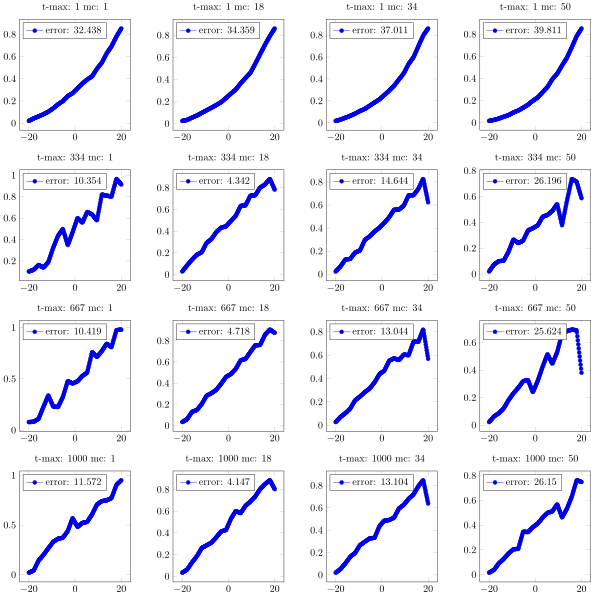

In [91]:
# plot all the value functions
g = GroupPlot(t_max_nbins, mc_nbins, groupStyle = "horizontal sep = 1.5cm, vertical sep = 1.4cm")
states = reshape(collect(linspace(env.xmin, env.xmax, num_eval_steps)), 1, num_eval_steps)
for (i, t_max) in enumerate(t_max_list)
    for (j, mc_runs) in enumerate(mc_runs_list)
        p = Axis(Plots.Linear(states[1,:], vs[:,i,j], legendentry="error: $(round(results[i,j],3))"), 
            width="5.5cm", 
            height="5.5cm",
            legendPos="north west",
            title=string("t-max: $(t_max) mc: $(mc_runs)"))
        push!(g, p)
    end
end
g

[32.4383 34.3589 37.0109 39.8111; 10.3538 4.34183 14.6443 26.1962; 10.4194 4.71783 13.0444 25.6235; 11.572 4.14737 13.1044 26.1499]


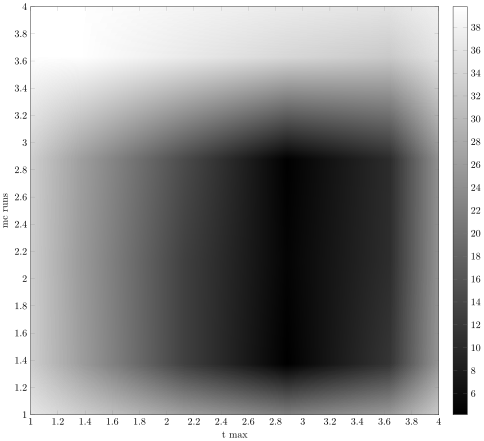

In [92]:
# heatmap the results
println(results)
function get_results_heat(x, y)
    return results[Int(floor(x)), Int(floor(y))]
end

xbins = length(t_max_list)
ybins = length(mc_runs_list)
img = Axis(Plots.Image(get_results_heat, (1, xbins), (1, ybins), xbins=xbins, ybins=ybins), 
        width="16cm", 
        height="16cm",
        xlabel="t max",
        ylabel="mc runs")
